# 2019 Mashine Learning course at the Faculty of Physics, Astronomy and Applied Computer Science

## Lab class no. 10 - Introduction to Neural Networks 2
by Piotr Warchoł

In this notebook, we will build some neural network models for data science problems using Keras.

The code is based on companion Jupyter notebooks for the book "Deep Learning with Python".


First, read this https://machinelearningmastery.com/introduction-python-deep-learning-library-keras/ blog post on what Keras library is and how to install it on your computer.


In [1]:
#The usuall stuff:

# To support both python 2 and python 3
# from __future__ import division, print_function, unicode_literals

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize']=12,10



import numpy as np
import random
#import os

import warnings
warnings.filterwarnings('ignore')



# to make this notebook's output stable across runs
np.random.seed(21)

In [2]:
%matplotlib inline

In [3]:
!python --version

Python 3.6.7


In [5]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

### Part 1: Utility of Keras 
First, look how easy it is to construct a neural network that will tacle the MNIST dataset classification problem.

In [6]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [7]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


Here our network consists of a sequence of two Dense layers, which are densely-connected (also called "fully-connected") neural layers. The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

- A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
- An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
- Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [8]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval. Previously, our training images for instance were stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [9]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

We also need to categorically encode the labels, a step which we explain in chapter 3:

In [10]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

We are now ready to train our network, which in Keras is done via a call to the fit method of the network: we "fit" the model to its training data.

In [11]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 6s 106us/step - loss: 0.2580 - acc: 0.9252
Epoch 2/5
60000/60000 [==============================] - 2s 41us/step - loss: 0.1032 - acc: 0.9694
Epoch 3/5
60000/60000 [==============================] - 2s 40us/step - loss: 0.0685 - acc: 0.9792
Epoch 4/5
60000/60000 [==============================] - 2s 39us/step - loss: 0.0502 - acc: 0.9852
Epoch 5/5
60000/60000 [==============================] - 2s 39us/step - loss: 0.0371 - acc: 0.9886


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

In [12]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 27us/step


In [13]:
print('test_acc:', test_acc)

test_acc: 0.9766


This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in less than 20 lines of Python code. In the next chapter, we will go in detail over every moving piece we just previewed, and clarify what is really going on behind the scenes. You will learn about "tensors", the data-storing objects going into the network, about tensor operations, which layers are made of, and about gradient descent, which allows our network to learn from its training examples.

## Part 2: First example - classifying movie reviews: a binary classification example

wo-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

The IMDB dataset
We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously you don't need your model to predict those). For instance, it is possible that your model could end up merely memorizing a mapping between your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [14]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 5s 0us/step


The argument num_words=10000 means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

The variables train_data and test_data are lists of reviews, each review being a list of word indices (encoding a sequence of words).  train_labels and test_labels are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [15]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [16]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [17]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words

In [18]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 3s 2us/step


In [19]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Preparing the data

We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

- We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).
- We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence  [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [20]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [21]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [22]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Building our network
Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of network that performs well on such a problem would be a simple stack of fully-connected (Dense) layers with relu activations: 

Dense(16,  activation='relu')

The argument being passed to each Dense layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension in the representation space of the layer. You may remember from the previous chapter that each such Dense layer with a relu activation implements the following chain of tensor operations:

output = relu(dot(W, input) + b)

Having 16 hidden units means that the weight matrix W will have shape (input_dimension, 16), i.e. the dot product with W will project the input data onto a 16-dimensional representation space (and then we would add the bias vector b and apply the relu operation). You can intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

- How many layers to use.
- How many "hidden units" to chose for each layer.

For the time being, you will have to trust us with the following architecture choice: two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review. The intermediate layers will use relu as their "activation function", and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). A relu (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid "squashes" arbitrary values into the [0, 1] interval, thus outputting something that can be interpreted as a probability.

Here's the Keras implementation, very similar to the MNIST example you saw previously:

In [23]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the binary_crossentropy loss. It isn't the only viable choice: you could use, for instance, mean_squared_error. But crossentropy is usually the best choice when you are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the rmsprop optimizer and the binary_crossentropy loss function. Note that we will also monitor accuracy during training.

In [24]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We are passing our optimizer, loss function and metrics as strings, which is possible because rmsprop, binary_crossentropy and  accuracy are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss function or metric function. This former can be done by passing an optimizer class instance as the optimizer argument:

In [25]:
from  keras  import  optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

The latter can be done by passing function objects as the loss or metrics arguments:

In [26]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### Validating our approach
In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:

In [27]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the validation data as the validation_data argument:

In [28]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 293us/step - loss: 0.5084 - binary_accuracy: 0.7814 - val_loss: 0.3797 - val_binary_accuracy: 0.8684
Epoch 2/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.3004 - binary_accuracy: 0.9047 - val_loss: 0.3004 - val_binary_accuracy: 0.8897
Epoch 3/20
15000/15000 [==============================] - 3s 214us/step - loss: 0.2179 - binary_accuracy: 0.9285 - val_loss: 0.3087 - val_binary_accuracy: 0.8711
Epoch 4/20
15000/15000 [==============================] - 3s 191us/step - loss: 0.1750 - binary_accuracy: 0.9439 - val_loss: 0.2840 - val_binary_accuracy: 0.8830
Epoch 5/20
15000/15000 [==============================] - 2s 144us/step - loss: 0.1427 - binary_accuracy: 0.9543 - val_loss: 0.2841 - val_binary_accuracy: 0.8872
Epoch 6/20
15000/15000 [==============================] - 2s 155us/step - loss: 0.1150 - binary_accuracy: 0.9651 - val_loss: 0.3163 - val_bi

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. Let's take a look at it:

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy:

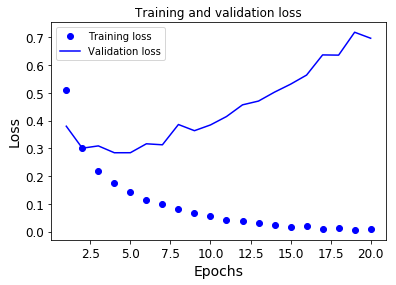

In [30]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

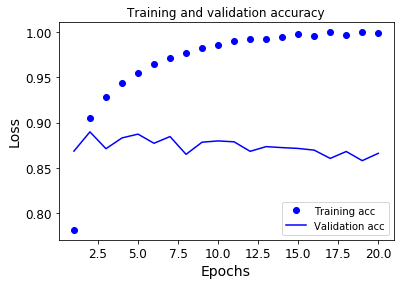

In [31]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. Note that your own results may vary slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. In general, there is a range of techniques you can leverage to mitigate overfitting, which we will cover in the next chapter.

Let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [32]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 113us/step - loss: 0.4746 - acc: 0.8212
Epoch 2/4
25000/25000 [==============================] - 2s 85us/step - loss: 0.2675 - acc: 0.9098
Epoch 3/4
25000/25000 [==============================] - 2s 67us/step - loss: 0.2010 - acc: 0.9286
Epoch 4/4
25000/25000 [==============================] - 3s 131us/step


In [33]:
results

[0.3225116212272644, 0.87348]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

### Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive by using the predict method:

In [34]:
model.predict(x_test)

array([[0.14020845],
       [0.99972576],
       [0.30727476],
       ...,
       [0.07340887],
       [0.04012939],
       [0.46948016]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).

### Further experiments
- We were using 2 hidden layers. Try to use 1 or 3 hidden layers and see how it affects validation and test accuracy.
- Try to use layers with more hidden units or less hidden units: 32 units, 64 units...
- Try to use the mse loss function instead of binary_crossentropy.
- Try to use the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be improved!

### Conclusions
Here's what you should take away from this example:

- There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
- Stacks of Dense layers with relu activations can solve a wide range of problems (including sentiment classification), and you will likely use them frequently.
- In a binary classification problem (two output classes), your network should end with a Dense layer with 1 unit and a sigmoid activation, i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
- With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is binary_crossentropy.
- The rmsprop optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry about.
- As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data never-seen-before. Make sure to always monitor performance on data that is outside of the training set.

## Part 3: Optimization and regularization

In the example we saw in the previous part  we could notice that the performance of our model on the held-out validation data would always peak after a few epochs and would then start degrading, i.e. our model would quickly start to overfit to the training data. Overfitting happens in every single machine learning problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on test data. While this is happening, your model is said to be under-fit: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, the best solution is of course to get more training data. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called regularization. Let's review some of the most common regularization techniques, and let's apply them in practice to improve our movie classification model from the previous chapter.

Note: in this notebook we will be using the IMDB test set as our validation set. 

#### Fighting overfitting

Reducing the network's size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the validation loss.

Let's try this on our movie review classification network. Our original network was as such:

In [35]:
original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

In [36]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

In [37]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 7s 284us/step - loss: 0.4590 - acc: 0.8230 - val_loss: 0.3596 - val_acc: 0.8638
Epoch 2/20
25000/25000 [==============================] - 7s 277us/step - loss: 0.2643 - acc: 0.9092 - val_loss: 0.2892 - val_acc: 0.8869
Epoch 3/20
25000/25000 [==============================] - 7s 270us/step - loss: 0.2005 - acc: 0.9279 - val_loss: 0.2823 - val_acc: 0.8861
Epoch 4/20
25000/25000 [==============================] - 7s 267us/step - loss: 0.1682 - acc: 0.9419 - val_loss: 0.2909 - val_acc: 0.8848
Epoch 5/20
25000/25000 [==============================] - 7s 266us/step - loss: 0.1469 - acc: 0.9479 - val_loss: 0.3202 - val_acc: 0.8770
Epoch 6/20
25000/25000 [==============================] - 7s 266us/step - loss: 0.1299 - acc: 0.9550 - val_loss: 0.3463 - val_acc: 0.8722
Epoch 7/20
25000/25000 [==============================] - 7s 272us/step - loss: 0.1148 - acc: 0.9608 - val_loss: 0.3526 - 

In [38]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 7s 269us/step - loss: 0.6009 - acc: 0.7012 - val_loss: 0.5538 - val_acc: 0.7056
Epoch 2/20
25000/25000 [==============================] - 6s 258us/step - loss: 0.5025 - acc: 0.8346 - val_loss: 0.4957 - val_acc: 0.8370
Epoch 3/20
25000/25000 [==============================] - 6s 259us/step - loss: 0.4532 - acc: 0.8801 - val_loss: 0.4681 - val_acc: 0.8596
Epoch 4/20
25000/25000 [==============================] - 7s 263us/step - loss: 0.4193 - acc: 0.9073 - val_loss: 0.4524 - val_acc: 0.8682
Epoch 5/20
25000/25000 [==============================] - 6s 250us/step - loss: 0.3932 - acc: 0.9230 - val_loss: 0.4425 - val_acc: 0.8725
Epoch 6/20
25000/25000 [==============================] - 6s 244us/step - loss: 0.3714 - acc: 0.9348 - val_loss: 0.4429 - val_acc: 0.8672
Epoch 7/20
25000/25000 [==============================] - 6s 248us/step - loss: 0.3522 - acc: 0.9431 - val_loss: 0.4398 - 

In [39]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

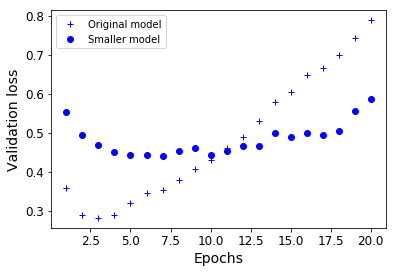

In [40]:
# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [41]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [42]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 14s 559us/step - loss: 0.4675 - acc: 0.7974 - val_loss: 0.3363 - val_acc: 0.8611
Epoch 2/20
25000/25000 [==============================] - 13s 516us/step - loss: 0.2244 - acc: 0.9078 - val_loss: 0.3127 - val_acc: 0.8664
Epoch 3/20
25000/25000 [==============================] - 13s 519us/step - loss: 0.1293 - acc: 0.9529 - val_loss: 0.3228 - val_acc: 0.8732
Epoch 4/20
25000/25000 [==============================] - 13s 509us/step - loss: 0.0663 - acc: 0.9813 - val_loss: 0.4273 - val_acc: 0.8814
Epoch 5/20
25000/25000 [==============================] - 13s 517us/step - loss: 0.0551 - acc: 0.9889 - val_loss: 0.5210 - val_acc: 0.8800
Epoch 6/20
25000/25000 [==============================] - 13s 514us/step - loss: 0.0799 - acc: 0.9893 - val_loss: 0.5574 - val_acc: 0.8703
Epoch 7/20
25000/25000 [==============================] - 13s 502us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the crosses are the initial network.

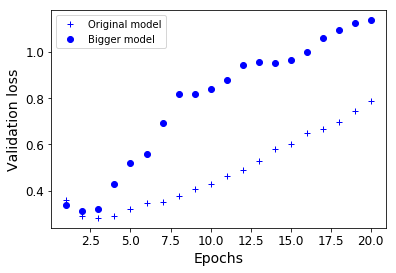

In [43]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also more noisy.

Meanwhile, here are the training losses for our two networks:

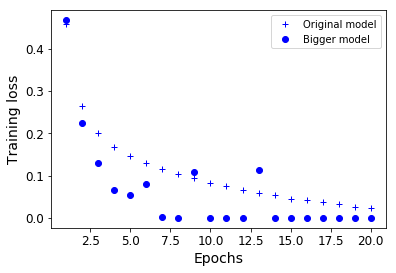

In [44]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

### Adding weight regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This, to some extent, also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization to our movie review classification network:

In [45]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [46]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than at test time.

Here's the impact of our L2 regularization penalty:

In [47]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 7s 285us/step - loss: 0.5213 - acc: 0.8078 - val_loss: 0.3977 - val_acc: 0.8782
Epoch 2/20
25000/25000 [==============================] - 6s 258us/step - loss: 0.3276 - acc: 0.9032 - val_loss: 0.3357 - val_acc: 0.8879
Epoch 3/20
25000/25000 [==============================] - 6s 248us/step - loss: 0.2769 - acc: 0.9176 - val_loss: 0.3518 - val_acc: 0.8755
Epoch 4/20
25000/25000 [==============================] - 6s 251us/step - loss: 0.2534 - acc: 0.9257 - val_loss: 0.3471 - val_acc: 0.8791
Epoch 5/20
25000/25000 [==============================] - 6s 252us/step - loss: 0.2398 - acc: 0.9314 - val_loss: 0.3428 - val_acc: 0.8814
Epoch 6/20
25000/25000 [==============================] - 6s 250us/step - loss: 0.2307 - acc: 0.9366 - val_loss: 0.3710 - val_acc: 0.8725
Epoch 7/20
25000/25000 [==============================] - 6s 244us/step - loss: 0.2227 - acc: 0.9385 - val_loss: 0.3773 - 

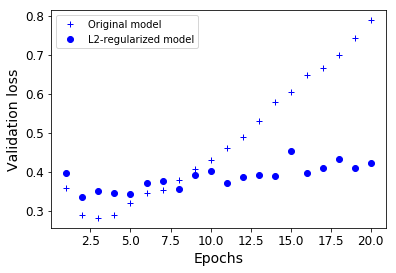

In [48]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [49]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

### Adding dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, layer_output, of shape (batch_size, features). At training time, we would be zero-ing out at random a fraction of the values in the matrix:

In [50]:
# At training time: we drop out 50% of the units in the output
# layer_output *= np.randint(0, high=2, size=layer_output.shape)

At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the units):

In [51]:
# At test time:
# layer_output *= 0.5

Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is often the way it is implemented in practice:

In [52]:
# At training time:
# layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Note that we are scaling *up* rather scaling *down* in this case
# layer_output /= 0.5

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among other things, by a fraud prevention mechanism used by banks -- in his own words: "I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting".

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present.

In Keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before it, e.g.:

In [53]:
model.add(layers.Dropout(0.5))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let's add two Dropout layers in our IMDB network to see how well they do at reducing overfitting:

In [54]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [55]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 8s 323us/step - loss: 0.6097 - acc: 0.6674 - val_loss: 0.4897 - val_acc: 0.8539
Epoch 2/20
25000/25000 [==============================] - 6s 251us/step - loss: 0.4700 - acc: 0.8129 - val_loss: 0.4043 - val_acc: 0.8638
Epoch 3/20
25000/25000 [==============================] - 6s 251us/step - loss: 0.3861 - acc: 0.8656 - val_loss: 0.3341 - val_acc: 0.8820
Epoch 4/20
25000/25000 [==============================] - 6s 249us/step - loss: 0.3237 - acc: 0.8937 - val_loss: 0.3039 - val_acc: 0.8830
Epoch 5/20
25000/25000 [==============================] - 6s 249us/step - loss: 0.2773 - acc: 0.9110 - val_loss: 0.2924 - val_acc: 0.8832
Epoch 6/20
25000/25000 [==============================] - 6s 251us/step - loss: 0.2458 - acc: 0.9216 - val_loss: 0.2968 - val_acc: 0.8814
Epoch 7/20
25000/25000 [==============================] - 6s 246us/step - loss: 0.2194 - acc: 0.9297 - val_loss: 0.3146 - 

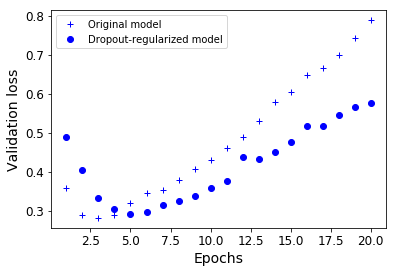

In [56]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

- Getting more training data.
- Reducing the capacity of the network.
- Adding weight regularization.
- Adding dropout.

## Part 4: 2nd Example: Classifying newswires: a multi-class classification

In part 2 we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. But what happens when you have more than two classes?

In this part, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

###The Reuters dataset

We will be working with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [57]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 1s 0us/step


Like with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [58]:
len(train_data)

8982

In [59]:
len(test_data)

2246

In [60]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [61]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 1s 2us/step


In [62]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [63]:
train_labels[10]

3

### Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [64]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [65]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [66]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Homework 10

### Your task now is to construct a neural network (in Keras) that learns clasification on this data set. Try to optimize and regularize it with the methods you have learned in class and by going thrugh this notebook. What is the best validation dataset score you can achieve?

Here's what you should take away from this example:

- If you are trying to classify data points between N classes, your network should end with a Dense layer of size N.
- In a single-label, multi-class classification problem, your network should end with a softmax activation, so that it will output a probability distribution over the N output classes.
- Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network, and the true distribution of the targets.
- There are two ways to handle labels in multi-class classification: Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using categorical_crossentropy as your loss function. Encoding the labels as integers and using the sparse_categorical_crossentropy loss function.
- If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having intermediate layers that are too small.